In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

Defining the optimizers (including the Symplectic Gradient Adjustment Optimizer) for empirical comparisons

In [15]:
def init_th(dims, std):
  th = []
  for i in range(len(dims)):
    if std > 0:
      init = torch.nn.init.normal_(torch.empty(dims[i], requires_grad=True), std=std)
    else:
      init = torch.zeros(dims[i], requires_grad=True)
    th.append(init)
  return th

def get_gradient(function, param):
  grad = torch.autograd.grad(function, param, create_graph=True)[0]
  return grad

def get_hessian(th, grad_L, diag=True, off_diag=True):
  n = len(th)
  H = []
  for i in range(n):
    row_block = []
    for j in range(n):
      if (i == j and diag) or (i != j and off_diag):
        block = [torch.unsqueeze(get_gradient(grad_L[i][i][k], th[j]), dim=0)
                  for k in range(len(th[i]))]
        row_block.append(torch.cat(block, dim=0))
      else:
        row_block.append(torch.zeros(len(th[i]), len(th[j])))
    H.append(torch.cat(row_block, dim=1))
  return torch.cat(H, dim=0)


def update_th(th, Ls, alpha, algo, a=0.5, b=0.1, gam=1, ep=0.1, lss_lam=0.1):
  n = len(th)
  losses = Ls(th)

  # Compute gradients
  grad_L = [[get_gradient(losses[j], th[i]) for j in range(n)] for i in range(n)]
  if algo == 'la':
    terms = [sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
                for j in range(n) if j != i]) for i in range(n)]
    grads = [grad_L[i][i]-alpha*get_gradient(terms[i], th[i]) for i in range(n)]

  elif algo == 'sga':
    xi = torch.cat([grad_L[i][i] for i in range(n)])
    ham = torch.dot(xi, xi.detach())
    H_t_xi = [get_gradient(ham, th[i]) for i in range(n)]
    H_xi = [get_gradient(sum([torch.dot(grad_L[j][i], grad_L[j][j].detach())
              for j in range(n)]), th[i]) for i in range(n)]
    A_t_xi = [H_t_xi[i]/2-H_xi[i]/2 for i in range(n)]
    # Compute lambda (sga with alignment)
    dot_xi = torch.dot(xi, torch.cat(H_t_xi))
    dot_A = torch.dot(torch.cat(A_t_xi), torch.cat(H_t_xi))
    d = sum([len(th[i]) for i in range(n)])
    lam = torch.sign(dot_xi*dot_A/d+ep)
    grads = [grad_L[i][i]+lam*A_t_xi[i] for i in range(n)]

  else: # Naive Learning
    grads = [grad_L[i][i] for i in range(n)]

  # Update theta
  with torch.no_grad():
    for i in range(n):
      th[i] -= alpha*grads[i]
  return th, losses

# Defining the problem

We start with a simple and popular problem - matching pennies. The Nash Equilibrium is at (0,0)

In [9]:
def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = torch.Tensor([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    p_1, p_2 = torch.sigmoid(th[0]), torch.sigmoid(th[1])
    x, y = torch.cat([p_1, 1-p_1]), torch.cat([p_2, 1-p_2])
    L_1 = torch.matmul(torch.matmul(x, payout_mat_1), y)
    L_2 = torch.matmul(torch.matmul(x, payout_mat_2), y)
    return [L_1, L_2]
  return dims, Ls

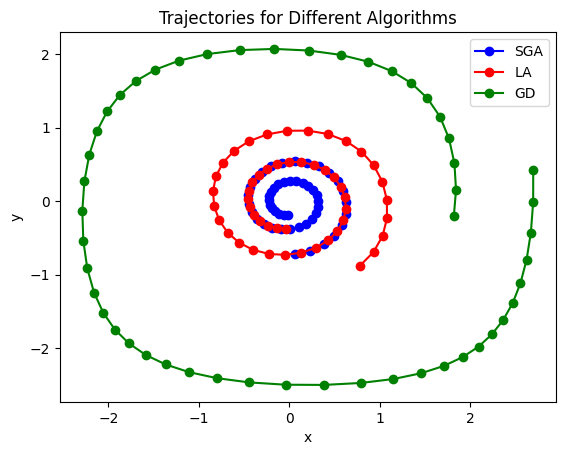

In [34]:
import copy
def calculate_l2_distance(x, y):
    return np.sqrt(x**2 + y**2)

def run_and_plot(algo, num_epochs=50, alpha=1, std=1):
    # Select game
    dims, Ls = matching_pennies()

    # Initialise theta ~ Normal(0, std)
    th = init_th(dims, std)

    # Run
    losses_out = np.zeros((num_epochs, len(th)))
    th_out = []
    distances = []
    for k in range(num_epochs):
        th, losses = update_th(th, Ls, alpha, algo)
        th_out.append(copy.deepcopy(th))
        losses_out[k] = [loss.data.numpy() for loss in losses]
        x , y = th[0].item(), th[1].item()
        distance_to_optimum = calculate_l2_distance(x,y)
        distances.append(distance_to_optimum)

    th_out_x = [th[0].item() for th in th_out]
    th_out_y = [th[1].item() for th in th_out]

    return th_out_x, th_out_y, losses_out, distances

# Run and plot for 'sga'
th_out_x_sga, th_out_y_sga, losses_out_sga, distances_sga = run_and_plot('sga')
plt.plot(th_out_x_sga, th_out_y_sga, marker='o', linestyle='-', color='b', label='SGA')

# Run and plot for 'la'
th_out_x_la, th_out_y_la, losses_out_la, distances_la = run_and_plot('la')
plt.plot(th_out_x_la, th_out_y_la, marker='o', linestyle='-', color='r', label='LA')

# Run and plot for 'gd'
th_out_x_gd, th_out_y_gd, losses_out_gd, distances_gd  = run_and_plot('gd')
plt.plot(th_out_x_gd, th_out_y_gd, marker='o', linestyle='-', color='g', label='GD')

plt.title('Trajectories for Different Algorithms')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

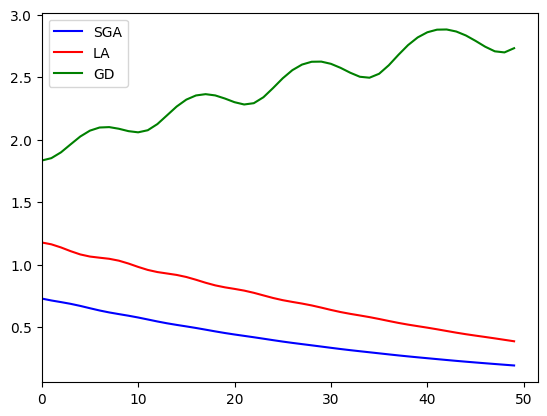

In [41]:
plt.plot(distances_sga, linestyle='-', color='b', label='SGA')
plt.plot(distances_la,  linestyle='-', color='r', label='LA')
plt.plot(distances_gd,linestyle='-', color='g', label='GD')
plt.xlim(left=0)
plt.legend()
plt.show()

We see that SGA reaches the optimum faster than Lookahead method for this simple problem